**Dataset:** [IMDB](https://ai.stanford.edu/~amaas/data/sentiment/)  

**Environment**  
* Windows-native: Version `Windows10-x64-Professional-22H2`

**Framework**  
* TensorFlow: Version `2.10.1`  

**Dependencies**  
* Python: Version `3.9.19`
* Pandas: Version `2.2.2`
* Numpy: Version `1.26.4`

RNN에서는 Input으로 Sequential Data를 받았는데, 이 중에서 Text를 예로 들어서 설명한다.  
Input이 300개의 token으로 이루어졌다고 했을 때 즉, 300개의 단어가 나열된 text라고 했을 때 **10번 째 단어에 대해서 분석할 때**는 **9번 째 단어를 0.5 만큼 기억**한 상태로 분석하게 되지만, **100번 째 단어에 대해서 분석할 때**는 **9번 째 단어를 (0.5)^10 만큼 기억**한 상태로 분석하기 때문에 9번 째 단어는 100번 째 단어 분석에 거의 영향을 미치지 못한다.  

이를 해결하기 위해 등장한 것이 LSTM과 GRU이다.  
LSTM(GRU도 마찬가지)에서는 **Forget Gate**를 추가해서 중요하다고 판단되는 정보는 기억하고, 아닌 정보는 forget한다 즉, noise는 forget한다.  
따라서 기억하려는 정보는 noise가 방해하지 않아서 더욱 오래 기억할 수 있고, noise는 학습하지 않기 때문에 overfitting을 방지할 수 있다.

In [8]:
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import pad_sequences

In [3]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(\
    num_words=500)

In [4]:
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

**cf. [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)**

In [5]:
# Create the model(1) - Single layer LSTM
model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=500,
                                 output_dim=16,
                                 input_length=100))
model.add(keras.layers.LSTM(units=8,
                            activation='tanh',
                            return_sequences=False))
model.add(keras.layers.Dense(units=1,
                             activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


> 어제 TensorFlow_03에서 fit 돌렸을 때랑 속도 차이가 엄청 나는데(_03에서가 체감상 10배 느림) 무슨 차인지 확인해볼 것.

In [6]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop,
              loss='binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    batch_size=64,
                    epochs=100,
                    verbose=2,
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 - 7s - loss: 0.6922 - accuracy: 0.5287 - val_loss: 0.6910 - val_accuracy: 0.5566 - 7s/epoch - 23ms/step
Epoch 2/100
313/313 - 2s - loss: 0.6885 - accuracy: 0.5944 - val_loss: 0.6859 - val_accuracy: 0.5834 - 2s/epoch - 8ms/step
Epoch 3/100
313/313 - 2s - loss: 0.6755 - accuracy: 0.6105 - val_loss: 0.6574 - val_accuracy: 0.6080 - 2s/epoch - 7ms/step
Epoch 4/100
313/313 - 2s - loss: 0.6204 - accuracy: 0.7050 - val_loss: 0.5976 - val_accuracy: 0.7346 - 2s/epoch - 7ms/step
Epoch 5/100
313/313 - 2s - loss: 0.5830 - accuracy: 0.7458 - val_loss: 0.5788 - val_accuracy: 0.7470 - 2s/epoch - 7ms/step
Epoch 6/100
313/313 - 2s - loss: 0.5621 - accuracy: 0.7580 - val_loss: 0.5613 - val_accuracy: 0.7504 - 2s/epoch - 7ms/step
Epoch 7/100
313/313 - 2s - loss: 0.5428 - accuracy: 0.7645 - val_loss: 0.5439 - val_accuracy: 0.7560 - 2s/epoch - 8ms/step
Epoch 8/100
313/313 - 2s - loss: 0.5243 - accuracy: 0.7716 - val_loss: 0.5265 - val_accuracy: 0.7612 - 2s/epoch - 8ms/step
Epoch 9/100
313

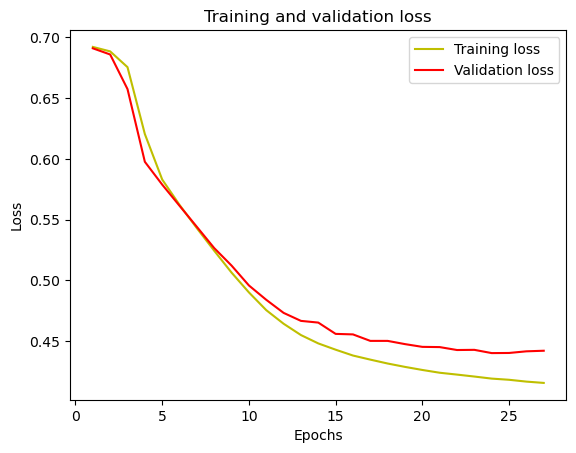

In [9]:
# Epoch에 따른 loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Create the model(2) - Single layer LSTM with dropout
# Dropout을 적용하여 overfitting을 더욱 방지하기
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(input_dim=500,
                                  output_dim=16,
                                  input_length=100))
model2.add(keras.layers.LSTM(units=8,
                             activation='tanh',
                             dropout=0.3,
                             return_sequences=False))
model2.add(keras.layers.Dense(units=1,
                              activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


In [11]:
model2.compile(optimizer=rmsprop,
               loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-with-dropout-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model2.fit(X_train, y_train,
                     validation_split=0.2,
                     batch_size=64,
                     epochs=100,
                     verbose=2,
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 - 5s - loss: 0.6928 - accuracy: 0.5174 - val_loss: 0.6920 - val_accuracy: 0.5462 - 5s/epoch - 15ms/step
Epoch 2/100
313/313 - 2s - loss: 0.6906 - accuracy: 0.5784 - val_loss: 0.6896 - val_accuracy: 0.6046 - 2s/epoch - 8ms/step
Epoch 3/100
313/313 - 2s - loss: 0.6861 - accuracy: 0.6260 - val_loss: 0.6823 - val_accuracy: 0.6418 - 2s/epoch - 8ms/step
Epoch 4/100
313/313 - 2s - loss: 0.6629 - accuracy: 0.6641 - val_loss: 0.6280 - val_accuracy: 0.7086 - 2s/epoch - 8ms/step
Epoch 5/100
313/313 - 2s - loss: 0.6032 - accuracy: 0.7210 - val_loss: 0.5877 - val_accuracy: 0.7288 - 2s/epoch - 8ms/step
Epoch 6/100
313/313 - 2s - loss: 0.5792 - accuracy: 0.7320 - val_loss: 0.5756 - val_accuracy: 0.7376 - 2s/epoch - 8ms/step
Epoch 7/100
313/313 - 2s - loss: 0.5587 - accuracy: 0.7460 - val_loss: 0.5493 - val_accuracy: 0.7484 - 2s/epoch - 8ms/step
Epoch 8/100
313/313 - 2s - loss: 0.5387 - accuracy: 0.7552 - val_loss: 0.5332 - val_accuracy: 0.7592 - 2s/epoch - 8ms/step
Epoch 9/100
313

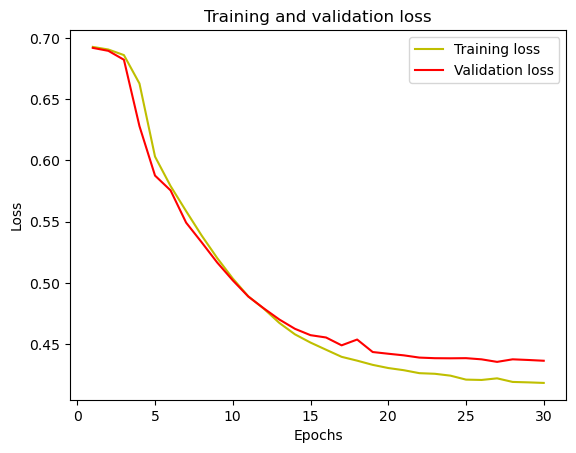

In [12]:
# Epoch에 따른 loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training과 Validation 사이의 간격이 좁아진 것을 확인 가능

In [13]:
# Create the model(3) - Multi layer LSTM with dropout
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(input_dim=500,
                                  output_dim=16,
                                  input_length=100))
model3.add(keras.layers.LSTM(units=8,
                             activation='tanh',
                             dropout=0.3,
# Recurrent layer의 hidden state는
# 마지막 timestep에 대한 hidden state만 다음 layer로 전달한다.
# ㄴ 즉 다음 layer로 전달되는 것은 sequential하지 않다.
# 하지만 Recurrent layer_1 다음에 또 Recurrent layer_2를 쌓는다면,
# Recurrent layer_2도 당연하게 sequential한 input을 기대한다.
# 이때 return_sequences=True로 설정하면, output이 sequential하게 출력
                             return_sequences=True))
model3.add(keras.layers.LSTM(units=8,
                             activation='tanh',
                             dropout=0.3))
model3.add(keras.layers.Dense(units=1,
                              activation='sigmoid'))

model3.summary()

# 첫 번째 lstm layer의 output shape가 (100, 8)인 것을 확인
# 즉 h1, h2, ... h100이 다음 layer의 input으로 들어감

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [14]:
model3.compile(optimizer=rmsprop,
               loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-multi-lstm-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model3.fit(X_train, y_train,
                     validation_split=0.2,
                     batch_size=64,
                     epochs=100,
                     verbose=2,
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 - 7s - loss: 0.6930 - accuracy: 0.5102 - val_loss: 0.6928 - val_accuracy: 0.5488 - 7s/epoch - 23ms/step
Epoch 2/100
313/313 - 4s - loss: 0.6923 - accuracy: 0.5724 - val_loss: 0.6912 - val_accuracy: 0.6172 - 4s/epoch - 12ms/step
Epoch 3/100
313/313 - 4s - loss: 0.6865 - accuracy: 0.6307 - val_loss: 0.6763 - val_accuracy: 0.6370 - 4s/epoch - 12ms/step
Epoch 4/100
313/313 - 4s - loss: 0.6364 - accuracy: 0.6829 - val_loss: 0.5956 - val_accuracy: 0.7130 - 4s/epoch - 12ms/step
Epoch 5/100
313/313 - 4s - loss: 0.5788 - accuracy: 0.7186 - val_loss: 0.5557 - val_accuracy: 0.7350 - 4s/epoch - 12ms/step
Epoch 6/100
313/313 - 4s - loss: 0.5429 - accuracy: 0.7426 - val_loss: 0.5270 - val_accuracy: 0.7458 - 4s/epoch - 12ms/step
Epoch 7/100
313/313 - 4s - loss: 0.5163 - accuracy: 0.7587 - val_loss: 0.5075 - val_accuracy: 0.7584 - 4s/epoch - 12ms/step
Epoch 8/100
313/313 - 4s - loss: 0.4972 - accuracy: 0.7692 - val_loss: 0.4918 - val_accuracy: 0.7654 - 4s/epoch - 12ms/step
Epoch 9/

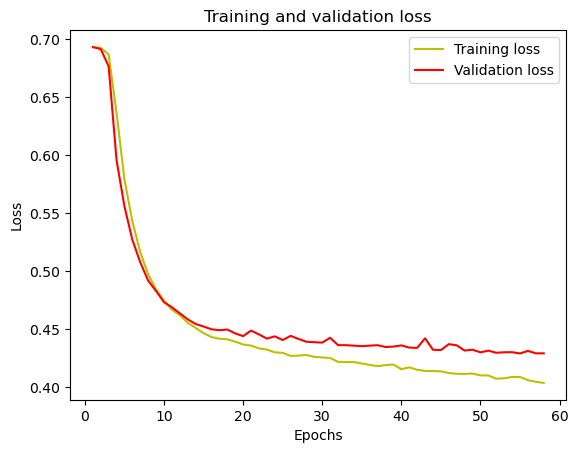

In [15]:
# Epoch에 따른 loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()